# Utils

In [ ]:
import numpy as np
import os
import random
from PIL import Image
import numpy as np

def LoadData(num_classes = 50, num_samples_per_class_train = 15, num_samples_per_class_test = 5, seed = 1, flatten=False, is_colab=False):
    """
    Load data and split it into training and testing
    Args:
        num_classes: number of classes adopted, -1 represents using all the classes
        num_samples_per_class_train: number of samples per class used for training
        num_samples_per_class_test: number of samples per class used for testing
        seed: random seed to ensure consistent results
    Returns:
        a tuple of (1) images for training (2) labels for training (3) images for testing, and (4) labels for testing
            (1) numpy array of shape [num_classes * num_samples_per_class_train, 784], binary pixels
            (2) numpy array of shape [num_classes * num_samples_per_class_train], integers of the class label
            (3) numpy array of shape [num_classes * num_samples_per_class_test, 784], binary pixels
            (4) numpy array of shape [num_classes * num_samples_per_class_test], integers of the class label
    """
    random.seed(seed)
    np.random.seed(seed)
    num_samples_per_class = num_samples_per_class_train + num_samples_per_class_test
    assert num_classes <= 1623
    assert num_samples_per_class <= 20

    # construct folders
    data_folder = '/content/drive/MyDrive/Colab Notebooks/Big Data Intelligence/data/omniglot_resized' if is_colab else './omniglot_resized'
    character_folders = [os.path.join(data_folder, family, character)
                         for family in os.listdir(data_folder)
                         if os.path.isdir(os.path.join(data_folder, family))
                         for character in os.listdir(os.path.join(data_folder, family))
                         if os.path.isdir(os.path.join(data_folder, family, character))]
    random.shuffle(character_folders)
    if num_classes == -1:
        num_classes = len(character_folders)
    else:
        character_folders = character_folders[:num_classes]

    # read images
    all_images = np.zeros(shape=(num_samples_per_class, num_classes, 28, 28))
    all_labels = np.zeros(shape=(num_samples_per_class, num_classes))
    label_images = get_images(character_folders, list(range(num_classes)), nb_samples=num_samples_per_class, shuffle=True)
    temp_count = np.zeros(num_classes, dtype=int)
    for label, imagefile in label_images:
        temp_num = temp_count[label]
        all_images[temp_num, label, :, :] = image_file_to_array(imagefile)
        all_labels[temp_num, label] = label
        temp_count[label] += 1

    # split and random permutate
    train_image = all_images[:num_samples_per_class_train].reshape(-1, 28, 28)
    test_image = all_images[num_samples_per_class_train:].reshape(-1, 28, 28)
    train_label = all_labels[:num_samples_per_class_train].reshape(-1)
    test_label = all_labels[num_samples_per_class_train:].reshape(-1)
    train_image, train_label = pair_shuffle(train_image, train_label)
    test_image, test_label = pair_shuffle(test_image, test_label)

    if(flatten):
        train_image = train_image.reshape(-1, 784)
        test_image = test_image.reshape(-1, 784)

    return train_image, train_label, test_image, test_label


def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler([pathstr for pathstr in os.listdir(path) if pathstr[-4:] == '.png' ])]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
    Returns:
        1 channel image
    """
    # Updated code as function was depricated
    image = Image.open(filename).convert('L')
    image = np.array(image)
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

def array_to_image_file(image_array, filename, dim_output):
    """
    Takes a numpy array and saves it as an image file.
    Args:
        image_array: Flattened numpy array of the image.
        filename: File path to save the image (including extension, e.g., .png).
        dim_output: Shape of the output image (e.g., [height, width] for 2D images).
    """
    # Reshape the array to the desired dimensions (height x width)
    image = image_array.reshape(dim_output)

    # Reverse the transformation from image_file_to_array
    image = 1.0 - image  
    image = (image * 255).astype(np.uint8) 

    # We can now use PIL to save the image
    pil_image = Image.fromarray(image)
    pil_image.save(filename)

def pair_shuffle(array_a, array_b):
    """
    Takes an image array and a label array
    Returns:
        the shuffled image array and label array
    """
    temp_perm = np.random.permutation(array_a.shape[0])
    array_a = array_a[temp_perm]
    array_b = array_b[temp_perm]
    return array_a, array_b

# Convolutional Neural Network

In [ ]:
# import libraries
import numpy as np
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

class ConvNN:
    def __init__(self, num_classes, num_samples_train, num_samples_test, seed, input_shape=(28, 28, 1), is_colab=False):
        self.num_classes = num_classes
        self.num_samples_train = num_samples_train
        self.num_samples_test = num_samples_test
        self.seed = seed
        self.input_shape = input_shape
        self.model = self.build_model()
        self.train_image, self.train_label, self.test_image, self.test_label = LoadData(num_classes, num_samples_train, num_samples_test, seed, False, is_colab)

    # The CNN Architecture, inspired by the one given in the homework
    def build_model(self):
        model = models.Sequential()

        # First Conv block: 28x28x1 -> 26x26x32 -> 26x26x32 -> 26x26x32 -> 13x13x32
        model.add(layers.Conv2D(32, (3, 3), padding='valid', input_shape=self.input_shape))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Conv2D(32, (3, 3), padding='valid'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Second Conv block: 13x13x32 -> 11x11x64 -> 11x11x64 -> 11x11x64 -> 5x5x64
        model.add(layers.Conv2D(64, (3, 3), padding='valid'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Conv2D(64, (3, 3), padding='valid'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Fully connected layers
        # Flatten: 5x5x64 -> 1600
        model.add(layers.Flatten())
        model.add(layers.Dense(512))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        return model

    def train_and_evaluate(self, model, learning_rate, epochs):
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=SparseCategoricalCrossentropy(),
            metrics=[SparseCategoricalAccuracy()],
        )
        history = model.fit(
            self.train_image,
            self.train_label,
            epochs=epochs,
            validation_data=(self.test_image, self.test_label),
            verbose=0,
        )
        return history

    def train_model(self, epochs=500, alpha=1e-5):
        history = self.train_and_evaluate(self.model, learning_rate=alpha, epochs=epochs)
        return history

    def train_multiple_models(self, learning_rates, epochs, print_output=True, plot_graph=True):
        results = []
        for lr in learning_rates:
            for epoch in epochs:
                model = self.build_model()
                history = self.train_and_evaluate(model, learning_rate=lr, epochs=epoch)
                final_val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]

                if print_output:
                    print(f"{final_val_accuracy:.3f}: {lr:.3f} x {epoch}")
                results.append((lr, epoch, final_val_accuracy))

        if plot_graph:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            learning_rates_plot, epoch_values_plot, val_accuracies_plot = zip(*results)

            sc = ax.scatter(learning_rates_plot, epoch_values_plot, val_accuracies_plot, c=val_accuracies_plot, cmap='viridis', s=100)
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Epochs')
            ax.set_zlabel('Validation Accuracy')
            plt.colorbar(sc, label='Validation Accuracy')
            plt.title('Learning Rate vs Epochs vs Validation Accuracy')
            plt.show()
        return results

    def show_n_predictions(self, n=10, print_output=True):
        for i in range(n):
            index = np.random.randint(0, self.test_image.shape[0])
            image = self.test_image[index].reshape(1, 28, 28, 1)
            prediction = self.model.predict(image)
            print(f"Predicted class: {np.argmax(prediction)}, Actual class: {self.test_label[index]}")

        if(print_output):
            test_loss, test_acc = self.model.evaluate(self.test_image, self.test_label, verbose=2)
            print(f"Test accuracy: {test_acc}")
            print(f"Test loss: {test_loss}")

# Fully Connected Neural Network

In [ ]:
class ConnectedNN:
    def __init__(self, num_classes, num_samples_train, num_samples_test, seed, is_colab=False):
        self.num_classes = num_classes
        self.num_samples_train = num_samples_train
        self.num_samples_test = num_samples_test
        self.seed = seed
        self.model = self.build_model()
        self.train_image, self.train_label, self.test_image, self.test_label = LoadData(num_classes, num_samples_train, num_samples_test, seed, True, is_colab)

    # The FCNN Architecture
    def build_model(self):
        model = models.Sequential()

        # Update input shape to match flattened input
        model.add(layers.Input(shape=(784,)))  # Flattened shape of 28x28

        # Add Dense layers with ReLU activation
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dropout(0.3))  # Add dropout for regularization
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(64, activation='relu'))

        # Output layer with softmax for classification
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        return model
    
    def train_and_evaluate(self, model, learning_rate, epochs):
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=SparseCategoricalCrossentropy(),
            metrics=[SparseCategoricalAccuracy()],
        )
        history = model.fit(
            self.train_image,
            self.train_label,
            epochs=epochs,
            validation_data=(self.test_image, self.test_label),
            verbose=0,
        )
        return history

    def train_model(self, epochs=500, alpha=1e-5):
        history = self.train_and_evaluate(self.model, learning_rate=alpha, epochs=epochs)
        return history
    
    def train_multiple_models(self, learning_rates, epochs, print_output=True, plot_graph=True):
        results = []
        for lr in learning_rates:
            for epoch in epochs:
                model = self.build_model()
                history = self.train_and_evaluate(model, learning_rate=lr, epochs=epoch)
                final_val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]

                if print_output:
                    print(f"{final_val_accuracy:.3f}: {lr:.3f} x {epoch}")
                results.append((lr, epoch, final_val_accuracy))

        if plot_graph:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            learning_rates_plot, epoch_values_plot, val_accuracies_plot = zip(*results)

            sc = ax.scatter(learning_rates_plot, epoch_values_plot, val_accuracies_plot, c=val_accuracies_plot, cmap='viridis', s=100)
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Epochs')
            ax.set_zlabel('Validation Accuracy')
            plt.colorbar(sc, label='Validation Accuracy')
            plt.title('Learning Rate vs Epochs vs Validation Accuracy')
            plt.show()
        return results

    def show_n_predictions(self, n=10, print_output=True):
        for i in range(n):
            index = np.random.randint(0, self.test_image.shape[0])
            image = self.test_image[index].reshape(1, 28, 28, 1)
            prediction = self.model.predict(image)
            print(f"Predicted class: {np.argmax(prediction)}, Actual class: {self.test_label[index]}")

        if(print_output):
            test_loss, test_acc = self.model.evaluate(self.test_image, self.test_label, verbose=2)
            print(f"Test accuracy: {test_acc}")
            print(f"Test loss: {test_loss}")

# Main




0.024: 0.500 x 100
0.020: 0.500 x 250
0.020: 0.500 x 500
0.024: 0.500 x 750
0.020: 0.500 x 1000
0.736: 0.100 x 100
0.592: 0.100 x 250
0.344: 0.100 x 500
0.020: 0.100 x 750
0.108: 0.100 x 1000
0.556: 0.050 x 100
0.816: 0.050 x 250
0.816: 0.050 x 500
0.856: 0.050 x 750
0.836: 0.050 x 1000
0.684: 0.010 x 100
0.836: 0.010 x 250
0.828: 0.010 x 500
0.860: 0.010 x 750
0.848: 0.010 x 1000
0.792: 0.005 x 100
0.812: 0.005 x 250
0.828: 0.005 x 500
0.848: 0.005 x 750
0.844: 0.005 x 1000


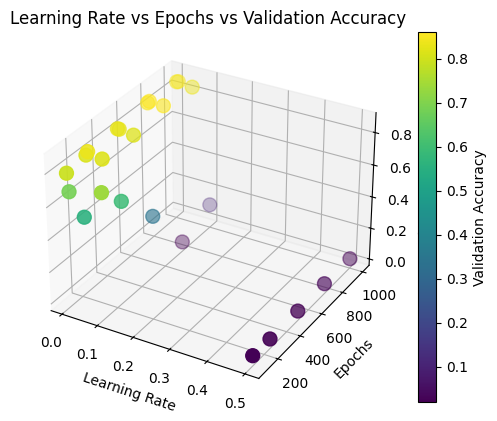

0.020: 0.100 x 500
0.020: 0.100 x 750
0.020: 0.100 x 1000
0.020: 0.100 x 1500
0.208: 0.010 x 500
0.156: 0.010 x 750
0.108: 0.010 x 1000
0.036: 0.010 x 1500
0.408: 0.005 x 500
0.408: 0.005 x 750
0.412: 0.005 x 1000
0.392: 0.005 x 1500
0.388: 0.001 x 500
0.432: 0.001 x 750
0.456: 0.001 x 1000
0.444: 0.001 x 1500
0.400: 0.001 x 500
0.408: 0.001 x 750
0.372: 0.001 x 1000
0.424: 0.001 x 1500
0.440: 0.000 x 500
0.440: 0.000 x 750
0.448: 0.000 x 1000
0.420: 0.000 x 1500
0.416: 0.000 x 500
0.440: 0.000 x 750
0.436: 0.000 x 1000
0.412: 0.000 x 1500
0.380: 0.000 x 500
0.432: 0.000 x 750
0.448: 0.000 x 1000
0.444: 0.000 x 1500


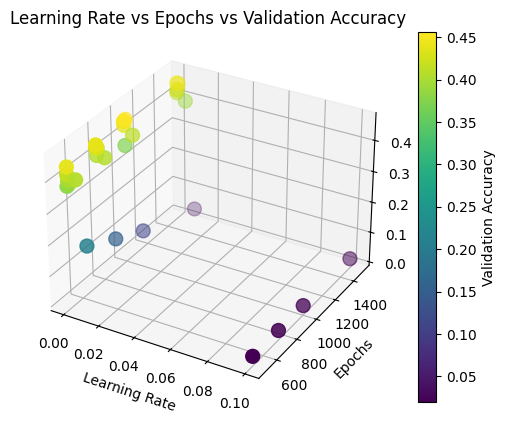

[(0.1, 500, 0.019999999552965164),
 (0.1, 750, 0.019999999552965164),
 (0.1, 1000, 0.019999999552965164),
 (0.1, 1500, 0.019999999552965164),
 (0.01, 500, 0.20800000429153442),
 (0.01, 750, 0.15600000321865082),
 (0.01, 1000, 0.1080000028014183),
 (0.01, 1500, 0.035999998450279236),
 (0.005, 500, 0.40799999237060547),
 (0.005, 750, 0.40799999237060547),
 (0.005, 1000, 0.41200000047683716),
 (0.005, 1500, 0.3919999897480011),
 (0.001, 500, 0.3880000114440918),
 (0.001, 750, 0.4320000112056732),
 (0.001, 1000, 0.4560000002384186),
 (0.001, 1500, 0.4440000057220459),
 (0.0005, 500, 0.4000000059604645),
 (0.0005, 750, 0.40799999237060547),
 (0.0005, 1000, 0.3720000088214874),
 (0.0005, 1500, 0.42399999499320984),
 (0.0001, 500, 0.4399999976158142),
 (0.0001, 750, 0.4399999976158142),
 (0.0001, 1000, 0.4480000138282776),
 (0.0001, 1500, 0.41999998688697815),
 (5e-05, 500, 0.41600000858306885),
 (5e-05, 750, 0.4399999976158142),
 (5e-05, 1000, 0.4359999895095825),
 (5e-05, 1500, 0.4120000004

In [ ]:
# Build and summarize the model
model_conv = ConvNN(num_classes=50, num_samples_train=15, num_samples_test=5, seed=1, is_colab=False)
model_conn = ConnectedNN(num_classes=50, num_samples_train=15, num_samples_test=5, seed=1, is_colab=False)

# Define ranges for ConvNN
# 0.024: 0.500 x 750
# 0.592: 0.100 x 250
# 0.856: 0.050 x 750
learning_rates_conv = [5e-2, 1e-2, 5e-3, 1e-3]
epoch_values_conv = [500, 1000, 1500]

# Define ranges for ConnectedNN
# 0.456: 0.001 x 1000
learning_rates_conn = [1e-2, 1e-3, 1e-4]
epoch_values_conn = [500, 1000, 2000]


# Training the models
model_conv.train_multiple_models(learning_rates_conv, epoch_values_conv, print_output=True, plot_graph=True)
model_conn.train_multiple_models(learning_rates_conn, epoch_values_conn, print_output=True, plot_graph=True)